In [1]:
import pandas as pd
import numpy as np

import gc
import glob

import warnings
warnings.filterwarnings("ignore")

In [2]:
file_path = "mimic-iii-clinical-database-carevue-subset-1.4/PATIENTS.csv.gz"
patients = pd.read_csv(file_path)

patients.head()

,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag
0,1,2,M,2138-07-17 00:00:00,NaN,NaN,NaN,0
1,2,3,M,2025-04-11 00:00:00,2102-06-14 00:00:00,NaN,2102-06-14 00:00:00,1
2,4,5,M,2103-02-02 00:00:00,NaN,NaN,NaN,0
3,6,7,F,2121-05-23 00:00:00,NaN,NaN,NaN,0
4,7,8,M,2117-11-20 00:00:00,NaN,NaN,NaN,0


In [3]:
file_path = "mimic-iii-clinical-database-carevue-subset-1.4/ICUSTAYS.csv.gz"
icu_stays = pd.read_csv(file_path)

icu_stays.head()

,row_id,subject_id,hadm_id,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los
0,1,2,163353,243653,carevue,NICU,NICU,56,56,2138-07-17 21:20:07,2138-07-17 23:32:21,0.0918
1,2,3,145834,211552,carevue,MICU,MICU,12,12,2101-10-20 19:10:11,2101-10-26 20:43:09,6.0646
2,4,5,178980,214757,carevue,NICU,NICU,56,56,2103-02-02 06:04:24,2103-02-02 08:06:00,0.0844
3,6,7,118037,278444,carevue,NICU,NICU,56,56,2121-05-23 15:35:29,2121-05-23 22:01:00,0.2677
4,7,7,118037,236754,carevue,NICU,NICU,56,56,2121-05-25 03:26:01,2121-05-25 21:10:19,0.7391


In [4]:
file_path = "mimic-iii-clinical-database-carevue-subset-1.4/ADMISSIONS.csv.gz"
admissions = pd.read_csv(file_path)

admissions.head()

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,1,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,NOT SPECIFIED,NaN,ASIAN,NaN,NaN,NEWBORN,0,1
1,2,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,MARRIED,WHITE,2101-10-20 17:09:00,2101-10-20 19:24:00,HYPOTENSION,0,1
2,4,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,BUDDHIST,NaN,ASIAN,NaN,NaN,NEWBORN,0,1
3,6,7,118037,2121-05-23 15:05:00,2121-05-27 11:57:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,CATHOLIC,NaN,WHITE,NaN,NaN,NEWBORN,0,1
4,7,8,159514,2117-11-20 10:22:00,2117-11-24 14:20:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,CATHOLIC,NaN,WHITE,NaN,NaN,NEWBORN,0,1


In [5]:
file_path = "mimic-iii-clinical-database-carevue-subset-1.4/D_ITEMS.csv.gz"
d_items = pd.read_csv(file_path)

In [7]:
file_path = "mimic-iii-clinical-database-carevue-subset-1.4/D_LABITEMS.csv.gz"
d_labitems = pd.read_csv(file_path)

### Patient Selection

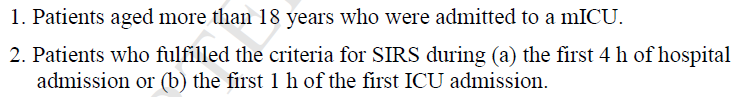

#### Nota

    - Critério acima não utilizado pois diverge do trabalho original de Calvert, 2017;

In [9]:
heart_rate_codes = [211, 220045, 3494, 188, 81, 549, 603, 2702, 8489, 8372, 8386, 8456, 8473]
resp_rate_codes = [614, 615, 618, 619, 3603, 1635, 1884, 220210, 224688, 224689, 224690]
temp_codes = [676, 223762, 677, 678, 679, 223761, 8537]
paCO2_codes = [778]
wbc_codes = [51300, 51301, 51516]
bands_codes = [51144]
wbc_chart_codes = [861, 1127, 1542, 220546]

sirs_criteria = {
    "temp_low": 36,       # Temperatura < 36°C
    "temp_high": 38,      # Temperatura > 38°C
    "heart_rate": 90,     # Frequência Cardíaca > 90 bpm
    "resp_rate": 20,      # Frequência Respiratória > 20/min
    "paCO2": 32,          # PaCO2 < 32 mmHg
    "wbc_high": 12000,    # WBC > 12000/mm³
    "wbc_low": 4000,      # WBC < 4000/mm³
    "bands": 10           # Bandas > 10%
}

admissions["admittime"] = pd.to_datetime(admissions["admittime"])
patients["dob"] = pd.to_datetime(patients["dob"])

def calculate_age(admittime, dob):
    return admittime.year - dob.year - ((admittime.month, admittime.day) < (dob.month, dob.day))

patients["age"] = [
    calculate_age(admit, dob) for admit, dob in zip(admissions["admittime"], patients["dob"])
]

# Critérios de inclusão
adult_patients = patients[patients["age"] >= 18]

merged = pd.merge(adult_patients, admissions, on="subject_id")
merged = pd.merge(merged, icu_stays, on=["subject_id", "hadm_id"])
merged = merged[merged['first_careunit'] == 'MICU']

In [10]:
icu_stay_data = pd.merge(
    icu_stays[["subject_id", "hadm_id", "intime"]],
    admissions[["subject_id", "hadm_id", "admittime"]],
    on=["subject_id", "hadm_id"],
    how="inner"
)

icu_stay_data["admittime"] = pd.to_datetime(icu_stay_data["admittime"])
icu_stay_data["intime"] = pd.to_datetime(icu_stay_data["intime"])

In [11]:
def process_chunk(chunk):
    chunk = chunk[chunk["hadm_id"].isin(merged["hadm_id"])]
    chunk = pd.merge(chunk, icu_stay_data, on=["hadm_id"], how="inner")

    chunk["charttime"] = pd.to_datetime(chunk["charttime"])
    chunk["intime"] = pd.to_datetime(chunk["intime"])
    
    heart_rate = chunk[chunk["itemid"].isin(heart_rate_codes)]
    heart_rate = heart_rate[heart_rate["valuenum"] > sirs_criteria["heart_rate"]]

    resp_rate = chunk[chunk["itemid"].isin(resp_rate_codes)]
    resp_rate = resp_rate[resp_rate["valuenum"] > sirs_criteria["resp_rate"]]

    paCO2 = chunk[chunk["itemid"].isin(paCO2_codes)]
    paCO2 = paCO2[paCO2["valuenum"] < sirs_criteria["paCO2"]]

    temp = chunk[chunk["itemid"].isin(temp_codes)].copy()
    if not temp.empty:
        temp["value_c"] = temp.apply(
            lambda row: (row["valuenum"] - 32) * 5 / 9 if row["itemid"] in [678, 679, 223761, 227054] else row["valuenum"], axis=1
        )
        temp = temp[(temp["value_c"] < sirs_criteria["temp_low"]) | (temp["value_c"] > sirs_criteria["temp_high"])]
        
    wbc = chunk[chunk["itemid"].isin(wbc_chart_codes)]
    wbc = wbc[(wbc["valuenum"] > sirs_criteria["wbc_high"]) | 
              (wbc["valuenum"] < sirs_criteria["wbc_low"])]

    return heart_rate, resp_rate, temp, paCO2, wbc

In [12]:
columns_needed = ["subject_id", "hadm_id", "itemid", "charttime", "valuenum"]
chartevents_chunks = pd.read_csv(
    "mimic-iii-clinical-database-carevue-subset-1.4/CHARTEVENTS.csv.gz",
    chunksize=800000,
    usecols=columns_needed,
    engine="python",
    on_bad_lines="skip"
)

heart_rate_results = []
resp_results = []
temp_results = []
paCO2_results = []
wbc_results = []

for i, chunk in enumerate(chartevents_chunks):
    heart_chunk, resp_chunk, temp_chunk, paCO2_chunk, wbc_chunk = process_chunk(chunk)
    heart_rate_results.append(heart_chunk)
    resp_results.append(resp_chunk)
    temp_results.append(temp_chunk)
    paCO2_results.append(paCO2_chunk)
    wbc_results.append(wbc_chunk)
    
    del chunk, heart_chunk, resp_chunk, temp_chunk, paCO2_chunk, wbc_chunk
    gc.collect()

    if (i + 1) % 10 == 0:
        if heart_rate_results:
            pd.concat(heart_rate_results, ignore_index=True).to_csv(f"processed-data/heart_rate_chunk_{i + 1}.csv", index=False)
            heart_rate_results = []
        if resp_results:
            pd.concat(resp_results, ignore_index=True).to_csv(f"processed-data/resp_rate_chunk_{i + 1}.csv", index=False)
            resp_results = []
        if temp_results:
            pd.concat(temp_results, ignore_index=True).to_csv(f"processed-data/temp_chunk_{i + 1}.csv", index=False)
            temp_results = []
        if paCO2_results:
            pd.concat(paCO2_results, ignore_index=True).to_csv(f"processed-data/paCO2_chunk_{i + 1}.csv", index=False)
            paCO2_results = []
        if wbc_results:
            pd.concat(wbc_results, ignore_index=True).to_csv(f"processed-data/wbc_chart_chunk_{i + 1}.csv", index=False)
            wbc_results = []

        gc.collect()

if heart_rate_results:
    pd.concat(heart_rate_results, ignore_index=True).to_csv("processed-data/heart_rate_chunk_final.csv", index=False)
if resp_results:
    pd.concat(resp_results, ignore_index=True).to_csv("processed-data/resp_rate_chunk_final.csv", index=False)
if temp_results:
    pd.concat(temp_results, ignore_index=True).to_csv("processed-data/temp_chunk_final.csv", index=False)
if paCO2_results:
    pd.concat(paCO2_results, ignore_index=True).to_csv("processed-data/paCO2_chunk_final.csv", index=False)
if wbc_results:
    pd.concat(wbc_results, ignore_index=True).to_csv("processed-data/wbc_chart_chunk_final.csv", index=False)

heart_rate_results = []
resp_results = []
temp_results = []
paCO2_results = []
wbc_results = []
gc.collect()

In [13]:
labevents_chunks = pd.read_csv(
    "mimic-iii-clinical-database-carevue-subset-1.4/LABEVENTS.csv.gz",
    usecols=["subject_id", "hadm_id", "itemid", "charttime", "valuenum"],
    chunksize=500000
)

wbc_results = []
bands_results = []

for i, chunk in enumerate(labevents_chunks):
    chunk = chunk[chunk["hadm_id"].isin(merged["hadm_id"])]
    chunk = pd.merge(chunk, icu_stay_data, on=["hadm_id"], how="inner")
    
    chunk["charttime"] = pd.to_datetime(chunk["charttime"])
    chunk["intime"] = pd.to_datetime(chunk["intime"])

    wbc_data = chunk[chunk["itemid"].isin(wbc_codes)]
    wbc_criteria = wbc_data[
        (wbc_data["valuenum"] > sirs_criteria["wbc_high"]) |
        (wbc_data["valuenum"] < sirs_criteria["wbc_low"])
    ]
    wbc_results.append(wbc_criteria)

    bands_data = chunk[chunk["itemid"].isin(bands_codes)]
    bands_criteria = bands_data[bands_data["valuenum"] > sirs_criteria["bands"]]
    bands_results.append(bands_criteria)

    if (i + 1) % 100 == 0:
        if wbc_results:
            pd.concat(wbc_results, ignore_index=True).to_csv(f"processed-data/wbc_chunk_{i + 1}.csv", index=False)
            wbc_results = []
        if bands_results:
            pd.concat(bands_results, ignore_index=True).to_csv(f"processed-data/bands_chunk_{i + 1}.csv", index=False)
            bands_results = []
        gc.collect()

if wbc_results:
    pd.concat(wbc_results, ignore_index=True).to_csv("processed-data/wbc_chunk_final.csv", index=False)
if bands_results:
    pd.concat(bands_results, ignore_index=True).to_csv("processed-data/bands_chunk_final.csv", index=False)

wbc_results = []
bands_results = []
gc.collect()

In [14]:
heart_rate_files = glob.glob("processed-data/heart_rate_chunk_*.csv")
resp_files = glob.glob("processed-data/resp_rate_chunk_*.csv")
temp_files = glob.glob("processed-data/temp_chunk_*.csv")
paCO2_files = glob.glob("processed-data/paCO2_chunk_*.csv")
wbc_files = glob.glob("processed-data/wbc_chunk_*.csv")
wbc_chart_files = glob.glob("processed-data/wbc_chart_chunk_*.csv")
bands_files = glob.glob("processed-data/bands_chunk_*.csv")

heart_rate_df = pd.concat([pd.read_csv(file) for file in heart_rate_files], ignore_index=True)
resp_df = pd.concat([pd.read_csv(file) for file in resp_files], ignore_index=True)
temp_df = pd.concat([pd.read_csv(file) for file in temp_files], ignore_index=True)
paCO2_df = pd.concat([pd.read_csv(file) for file in paCO2_files], ignore_index=True)
wbc_criteria = pd.concat([pd.read_csv(file) for file in wbc_files], ignore_index=True)
wbc_chart_criteria = pd.concat([pd.read_csv(file) for file in wbc_chart_files], ignore_index=True)
bands_criteria = pd.concat([pd.read_csv(file) for file in bands_files], ignore_index=True)

heart_rate_df["criteria"] = "heart_rate"
resp_df["criteria"] = "resp_rate"
temp_df["criteria"] = "temp"
paCO2_df["criteria"] = "paCO2"
wbc_criteria["criteria"] = "wbc"
wbc_chart_criteria["criteria"] = "wbc"
bands_criteria["criteria"] = "bands"

sirs_criteria_df = pd.concat([
    heart_rate_df[["hadm_id", "charttime", "criteria"]],
    resp_df[["hadm_id", "charttime", "criteria"]],
    temp_df[["hadm_id", "charttime", "criteria"]],
    paCO2_df[["hadm_id", "charttime", "criteria"]],
    wbc_criteria[["hadm_id", "charttime", "criteria"]],
    bands_criteria[["hadm_id", "charttime", "criteria"]]
], ignore_index=True)

sirs_criteria_df["charttime"] = pd.to_datetime(sirs_criteria_df["charttime"])

# Arredondar o tempo para a hora mais próxima
sirs_criteria_df["rounded_time"] = sirs_criteria_df["charttime"].dt.round("H")

# Contar critérios de SIRS por hadm_id e rounded_time
sirs_criteria_summary = (
    sirs_criteria_df
    .groupby(["hadm_id", "rounded_time"])["criteria"]
    .nunique()
    .reset_index()
    .rename(columns={"criteria": "sirs_criteria_count"})
)

patients_with_sirs = sirs_criteria_summary[sirs_criteria_summary["sirs_criteria_count"] >= 2]

# Identificar pacientes com SIRS persistente por 5 horas consecutivas
patients_with_sirs["flag_sirs_5h"] = (
    patients_with_sirs
    .groupby("hadm_id")["rounded_time"]
    .diff()
    .dt.total_seconds()
    .div(3600)
    .eq(1)
    .groupby(patients_with_sirs["hadm_id"])
    .cumsum()
    .ge(5)
)

# Identificar a primeira hora de SIRS contínuo de 5 horas
first_sirs_persistent_time = (
    patients_with_sirs[patients_with_sirs["flag_sirs_5h"]]
    .groupby("hadm_id")["rounded_time"]
    .min()
    .reset_index()
    .rename(columns={"rounded_time": "first_sirs_5h_time"})
)

# Ajusta o horário do primeiro SIRS para a hora inicial
first_sirs_persistent_time["first_sirs_5h_time"] = (
    first_sirs_persistent_time["first_sirs_5h_time"] - pd.Timedelta(hours=4)
)

patients_with_sirs_summary = (
    patients_with_sirs
    .groupby("hadm_id")["sirs_criteria_count"]
    .max()
    .reset_index()
    .merge(first_sirs_persistent_time, on="hadm_id", how="left")
)

icu_stays["intime"] = pd.to_datetime(icu_stays["intime"])
sirs_criteria_df = sirs_criteria_summary[sirs_criteria_summary['sirs_criteria_count'] >= 2]

merged_df = pd.merge(icu_stays, sirs_criteria_df, on='hadm_id', how='inner')
merged_df['intime_plus_horas'] = merged_df['intime'] + pd.to_timedelta(3, unit='h')
filtered_df = merged_df[merged_df['rounded_time'] <= merged_df['intime_plus_horas']]

# Ids de pacientes que tiveram SIRS nas primeiras 4 horas de internação
ids_para_remover = filtered_df['hadm_id'].unique()
patients_with_sirs_summary = patients_with_sirs_summary[~patients_with_sirs_summary['hadm_id'].isin(ids_para_remover)]

In [15]:
patients_with_sirs_summary

,hadm_id,sirs_criteria_count,first_sirs_5h_time
1,100017.0,2,NaT
4,100109.0,3,NaT
8,100154.0,2,NaT
16,100220.0,2,NaT
17,100237.0,2,NaT
...,...,...,...
5308,199855.0,3,2116-12-15 07:00:00
5309,199884.0,3,NaT
5310,199888.0,2,NaT
5311,199919.0,3,2178-09-27 09:00:00


In [16]:
patients_with_5h_persistent_sirs = patients_with_sirs_summary[~patients_with_sirs_summary['first_sirs_5h_time'].isna()]

### Pacientes com SIRS persistente por no mínimo 5 horas e que não tiveram SIRS nas primeiras 4 horas da internação na UTI

In [17]:
patients_with_5h_persistent_sirs

,hadm_id,sirs_criteria_count,first_sirs_5h_time
20,100283.0,3,2168-12-06 09:00:00
22,100335.0,4,2199-11-22 19:00:00
50,100837.0,3,2151-08-31 19:00:00
54,100918.0,3,2123-08-14 00:00:00
62,101005.0,3,2128-07-06 19:00:00
...,...,...,...
5272,199340.0,3,2174-03-07 14:00:00
5279,199505.0,3,2133-04-25 10:00:00
5308,199855.0,3,2116-12-15 07:00:00
5311,199919.0,3,2178-09-27 09:00:00


### Separar, dentre esses, quais tiveram sepse diagnosticada

    - Para isso vou verificar quais possuem o código 995.9

In [18]:
file_path = "mimic-iii-clinical-database-carevue-subset-1.4/DIAGNOSES_ICD.csv.gz"
diagnoses = pd.read_csv(file_path)

diagnoses["icd9_code"] = diagnoses["icd9_code"].fillna("")

# sepsis_diagnoses = diagnoses[(diagnoses["icd9_code"].str.startswith("9959"))]

sepsis_diagnoses = diagnoses[(diagnoses["icd9_code"].str.startswith("99591")) | 
                             (diagnoses["icd9_code"].str.startswith("99592")) |
                            (diagnoses["icd9_code"].str.startswith("78552")) ]

sirs_with_sepsis = patients_with_5h_persistent_sirs.merge(sepsis_diagnoses, on="hadm_id", how="inner")

num_sepsis_patients = sirs_with_sepsis["hadm_id"].nunique()
print(f"Número de pacientes em SIRS com diagnóstico de sepse (ICD-9 995.9): {num_sepsis_patients}")

sepsis_hadm_ids = set(sirs_with_sepsis["hadm_id"].unique())

patients_with_5h_persistent_sirs["sepsis"] = patients_with_5h_persistent_sirs["hadm_id"].apply(
    lambda x: 1 if x in sepsis_hadm_ids else 0)

Número de pacientes em SIRS com diagnóstico de sepse (ICD-9 995.9): 79


In [19]:
patients_with_5h_persistent_sirs

,hadm_id,sirs_criteria_count,first_sirs_5h_time,sepsis
20,100283.0,3,2168-12-06 09:00:00,0
22,100335.0,4,2199-11-22 19:00:00,0
50,100837.0,3,2151-08-31 19:00:00,0
54,100918.0,3,2123-08-14 00:00:00,0
62,101005.0,3,2128-07-06 19:00:00,0
...,...,...,...,...
5272,199340.0,3,2174-03-07 14:00:00,0
5279,199505.0,3,2133-04-25 10:00:00,1
5308,199855.0,3,2116-12-15 07:00:00,1
5311,199919.0,3,2178-09-27 09:00:00,1


In [20]:
filtered_sirs_patients = patients_with_5h_persistent_sirs[patients_with_5h_persistent_sirs['sepsis'] == 1]
filtered_sirs_patients.to_csv("sepsis_patients.csv", index=False)

print(f"Arquivo 'sepsis_patients.csv' salvo com {len(filtered_sirs_patients)} pacientes.")

Arquivo 'sepsis_patients.csv' salvo com 79 pacientes.


### Separação dos pacientes negativos para sepse

    - Idade maior que 18 anos
    - Admitidos na MICU
    - Sem SIRS nas primeiras 4 horas de internação

In [21]:
# Df com pacientes com mais de 18 anos e admitidos na MICU
merged.head()

,row_id_x,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,age,row_id_y,...,row_id,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los
0,2,3,M,2025-04-11,2102-06-14 00:00:00,NaN,2102-06-14 00:00:00,1,76,2,...,2,211552,carevue,MICU,MICU,12,12,2101-10-20 19:10:11,2101-10-26 20:43:09,6.0646
1,8,9,M,2108-01-26,2149-11-14 00:00:00,2149-11-14 00:00:00,2149-11-14 00:00:00,1,41,8,...,9,220597,carevue,MICU,MICU,15,15,2149-11-09 13:07:02,2149-11-14 20:52:14,5.3231
8,18,21,M,2047-04-04,2135-02-08 00:00:00,2135-02-08 00:00:00,2135-02-08 00:00:00,1,87,20,...,21,216859,carevue,MICU,MICU,52,52,2135-01-30 20:53:34,2135-02-08 05:38:46,8.3647
14,27,31,M,2036-05-17,2108-08-30 00:00:00,2108-08-30 00:00:00,2108-08-30 00:00:00,1,136,30,...,31,254478,carevue,MICU,MICU,15,15,2108-08-22 23:28:42,2108-08-30 21:59:20,7.9379
15,29,33,M,2034-08-02,NaN,NaN,NaN,0,135,32,...,33,296681,carevue,MICU,MICU,12,12,2116-12-23 22:31:53,2116-12-25 11:49:55,1.5542


In [22]:
patients_without_sirs_in_first_hours = merged[~merged['hadm_id'].isin(ids_para_remover)]

### Verificar ausência de sepse

    - Irei remover pacientes que possuem qualquer código relacionado a sepse 

In [23]:
sepsis_codes = ["038", "9959", "78552"]

sepsis_cases = diagnoses[
    diagnoses["icd9_code"].str.startswith(tuple(sepsis_codes))
]

sepsis_hadm_ids = sepsis_cases["hadm_id"].unique()

no_sepsis_patients = patients_without_sirs_in_first_hours[
    ~patients_without_sirs_in_first_hours["hadm_id"].isin(sepsis_hadm_ids)
]

In [24]:
no_sepsis_patients

,row_id_x,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,age,row_id_y,...,row_id,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los
1,8,9,M,2108-01-26,2149-11-14 00:00:00,2149-11-14 00:00:00,2149-11-14 00:00:00,1,41,8,...,9,220597,carevue,MICU,MICU,15,15,2149-11-09 13:07:02,2149-11-14 20:52:14,5.3231
14,27,31,M,2036-05-17,2108-08-30 00:00:00,2108-08-30 00:00:00,2108-08-30 00:00:00,1,136,30,...,31,254478,carevue,MICU,MICU,15,15,2108-08-22 23:28:42,2108-08-30 21:59:20,7.9379
27,52,59,F,2110-10-12,2198-09-06 00:00:00,2198-09-06 00:00:00,2198-09-06 00:00:00,1,73,58,...,60,224440,carevue,MICU,MICU,50,50,2197-11-14 17:07:48,2197-11-16 21:58:12,2.2017
31,56,63,M,2080-07-07,NaN,NaN,NaN,0,37,63,...,65,244541,carevue,MICU,MICU,52,52,2169-01-07 01:52:56,2169-01-07 14:25:27,0.5226
41,70,78,M,2128-07-01,2180-02-02 00:00:00,NaN,2180-02-02 00:00:00,1,42,79,...,82,233150,carevue,MICU,MICU,12,12,2177-02-14 04:10:26,2177-02-15 15:54:43,1.4891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19757,30512,32495,F,2120-01-31,2186-10-25 00:00:00,NaN,2186-10-25 00:00:00,1,28,39417,...,40961,294276,carevue,MICU,MICU,50,50,2186-08-13 02:00:46,2186-08-17 15:39:56,4.5689
19769,30566,32554,F,2043-06-22,NaN,NaN,NaN,0,142,39486,...,41032,252881,carevue,MICU,MICU,50,50,2118-09-07 12:23:57,2118-09-09 23:45:15,2.4731
19776,30592,32584,M,2067-03-04,2151-10-12 00:00:00,NaN,2151-10-12 00:00:00,1,37,39516,...,41062,270274,carevue,MICU,MICU,50,50,2147-08-21 06:57:53,2147-08-23 14:40:00,2.3209
19801,30648,32643,F,2019-08-12,NaN,NaN,NaN,0,110,39586,...,41130,274492,carevue,MICU,SICU,50,33,2107-10-16 22:22:38,2107-10-21 18:23:14,4.8338


In [25]:
no_sepsis_patients.to_csv("no_sepsis_patients.csv", index=False)

print(f"Arquivo 'no_sepsis_patients.csv' salvo com {len(no_sepsis_patients)} pacientes.")

Arquivo 'no_sepsis_patients.csv' salvo com 1930 pacientes.


## Notas

        - O diagnóstico de sepse pode ser um problema. Os autores deixam de buscar por outros códigos também relacionados a sepse, e também deixa marcado como negativos pacientes que tiveram choque séptico sem ter o código de apenas "sepse".

In [26]:
file_path = "mimic-iii-clinical-database-carevue-subset-1.4/D_ICD_DIAGNOSES.csv.gz"
icd_diagnoses = pd.read_csv(file_path)

In [27]:
sepsis_codes = ["038", "99591", "99592", "78552"]

sepsis_cases = icd_diagnoses[
    icd_diagnoses["icd9_code"].str.startswith(tuple(sepsis_codes))
]

sepsis_cases

,row_id,icd9_code,short_title,long_title
645,646,0380,Streptococcal septicemia,Streptococcal septicemia
646,647,03810,Staphylcocc septicem NOS,"Staphylococcal septicemia, unspecified"
647,648,03811,Meth susc Staph aur sept,Methicillin susceptible Staphylococcus aureus ...
648,649,03812,MRSA septicemia,Methicillin resistant Staphylococcus aureus se...
649,650,03819,Staphylcocc septicem NEC,Other staphylococcal septicemia
650,651,0382,Pneumococcal septicemia,Pneumococcal septicemia [Streptococcus pneumon...
651,652,0383,Anaerobic septicemia,Septicemia due to anaerobes
652,653,03840,Gram-neg septicemia NOS,"Septicemia due to gram-negative organism, unsp..."
653,654,03841,H. influenae septicemia,Septicemia due to hemophilus influenzae [H. in...
654,655,03842,E coli septicemia,Septicemia due to escherichia coli [E. coli]
